# Scripting Sculptor 03 - Fitting and Analzying models using MCMC

This tutorial notebook focuses on using *Sculptor's* modules to fit and analyze a model using the maxmimum likelihood Markov Chain Monte Carlo method implemented in [LMFIT](https://lmfit.github.io/lmfit-py/index.html) using the [emcee](https://emcee.readthedocs.io/en/stable/#) backend. You can find more information on how LMFIT uses emcee [here](https://lmfit.github.io/lmfit-py/examples/example_emcee_Model_interface.html).

In [1]:
%matplotlib inline

import corner
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM

from sculptor import specfit as scfit
from sculptor import specmodel as scmod

[INFO] Import "sculptor_extensions" package: my_extension
[INFO] Import "sculptor_extensions" package: qso
[INFO] SWIRE library found.
[INFO] FeII iron template of Vestergaard & Wilkes 2001 found. If you will be using these templates in your model fit and publication, please add the citation to the original work, ADS bibcode: 2001ApJS..134....1V
[INFO] FeII iron template of Tsuzuki et al. 2006 found. If you will be using these templates in your model fit and publication, please add the citation to the original work, ADS bibcode: 2006ApJ...650...57T
[INFO] FeII iron template of Boroson & Green 1992 found. If you will be using these templates in your model fit and publication, please add the citation to the original work, ADS bibcode: 1992ApJS...80..109B


## Fitting a model using MCMC

We begin by loading the example spectrum fit to an SDSS quasar spectrum we have been using in previous tutorials. 

In [2]:
# Instantiate an empty SpecFit object
fit = scfit.SpecFit()
# Load the example spectrum fit
fit.load('../example_spectrum_fit')

In the next step we need to change the fitting method. Just as a reminder the full list of fitting methods is available as a globa variable in the *SpecModel* module:

In [3]:
for key in scmod.fitting_methods:
    print('Name: {} \n Method {}'.format(key, scmod.fitting_methods[key]))

Name: Levenberg-Marquardt 
 Method leastsq
Name: Nelder-Mead 
 Method nelder
Name: Maximum likelihood via Monte-Carlo Markov Chain 
 Method emcee
Name: Least-Squares minimization 
 Method least_squares
Name: Differential evolution 
 Method differential_evolution
Name: Brute force method 
 Method brute
Name: Basinhopping 
 Method basinhopping
Name: Adaptive Memory Programming for Global Optimization 
 Method ampgo
Name: L-BFGS-B 
 Method lbfgsb
Name: Powell 
 Method powell
Name: Conjugate-Gradient 
 Method cg
Name: Cobyla 
 Method cobyla
Name: BFGS 
 Method bfgs
Name: Truncated Newton 
 Method tnc
Name: Newton GLTR trust-region 
 Method trust-krylov
Name: Trust-region for constrained obtimization 
 Method trust-constr
Name: Sequential Linear Squares Programming 
 Method slsqp
Name: Simplicial Homology Global Optimization 
 Method shgo
Name: Dual Annealing Optimization 
 Method dual_annealing


Let us now set the fitting method to 'Maximum likelihood via Monte-Carlo Markov Chain'.

In [4]:
# Setting the fit method to MCMC via emcee
fit.fitting_method = 'Maximum likelihood via Monte-Carlo Markov Chain'

This fitting method takes additional keyword arguments that specify
* the number of MCMC steps (*steps*),
* the number of steps considered to be the burn in phase (*burn*), which will be discarded,
* the number of walkers (*nwalkers*), which should be a much larger number than your variables
* the number of workers (*workers*) for multiprocessing (*workers=4* will spawn a multiprocessing-based pool with  4 parallel processes),
* thin sampling accepting only 1 in every *thin* (int) samples,
* whether the objective function has been weightes by measurement uncertainties (*is_weighted*, boolean),
* whether a progress bar should be printed (*progress*, boolean),
* and the *seed* (default: *seed=1234*).

**Note:** The *is_weighted* keyword will be set to *True* by default. 

For a full documentation of the keyword arguments, please visit the [LMFIT emcee documentation](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.Minimizer.emcee). The list of keyword arguments can be accessed via *SpecFit.emcee_kws*. 

In [5]:
for key in fit.emcee_kws:
    print(key, fit.emcee_kws[key])

steps 1000
burn 300
thin 20
nwalkers 50
workers 1
is_weighted True
progress False
seed 1234


Additional keywords can be added to this dictionary, which will be passed to the *SpecModel* fit function, once the *SpecFit* fitting method has been selected to be MCMC (see above). 

The default values **do not automatically constitute a good default choice**. The choice of those parameters is highly dependent on the model fit (e.g., number of variable parameters). In order to properly fit the CIV emission line we will adjust them:

In [6]:
# Set the MCMC keywords
fit.emcee_kws['steps'] = 2000
fit.emcee_kws['burn'] = 500
# We are fitting 6 parameters so nwalker=50 is fine
fit.emcee_kws['nwalkers'] = 25
# No multiprocessing for now
fit.emcee_kws['workers'] = 1
fit.emcee_kws['thin'] = 2
fit.emcee_kws['progress'] = True
# Take uncertainties into account
fit.emcee_kws['is_weighted'] = True

**Before fitting any model using MCMC it is strongly advised to fit the model with a standard algorithm (e.g., 'Levenberg-Marquardt') after setting it up and then start the MCMC fit from the best-fit parameters.**

In our case we already fitted all models to the quasar spectrum before saving it. Therefore, we can immediately fit the CIV emission line model. 

In [7]:
# In case we have forgotten the index of the CIV SpecModel in the fit.specmodels list.
for idx, specmodel in enumerate(fit.specmodels):
    print(idx, specmodel.name)

0 Continuum
1 SiIV_line
2 CIV_line
3 CIII]_complex
4 Abs_lines


In [8]:
# Select the CIV emission line SpecModel
civ_model = fit.specmodels[2]

# Fit the SpecModel using the MCMC method and emcee_kws modified above
civ_model.fit()

# Print the fit result
print(civ_model.fit_result.fit_report())

100%|██████████| 2000/2000 [00:06<00:00, 288.42it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [60.71255358 65.93961611 64.03676477 66.17055916 63.93059079 73.11907444
 61.57293084]
[[Model]]
    (Model(line_model_gaussian, prefix='CIV_B_') + Model(line_model_gaussian, prefix='CIV_A_'))
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 309
    # variables        = 7
    chi-square         = 301.595330
    reduced chi-square = 0.99866003
    Akaike info crit   = 6.50516627
    Bayesian info crit = 32.6385552
[[Variables]]
    CIV_B_z:          3.21141536 +/- 8.0272e-04 (0.02%) (init = 3.209845)
    CIV_B_flux:       1091.60304 +/- 132.570578 (12.14%) (init = 1151.246)
    CIV_B_cen:        1549.06 (fixed)
    CIV_B_fwhm_km_s:  4704.44704 +/- 244.820184 (5.20%) (init = 4790.818)
    CIV_A_z:          3.20746100 +/- 0.00166939 (0.05%) (init = 3.209726)
    CIV_A_flux:

We visualize the fit result by plotting the CIV model fit.

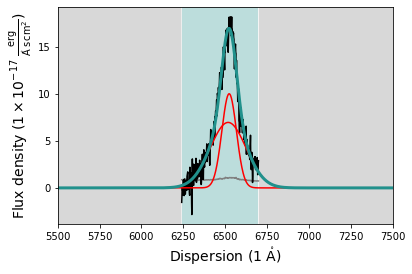

In [9]:
# Plot the fitted model 
civ_model.plot(xlim=[5500,7500])

However, much more important is that we have a look at the sampled parameter space and the posterior distributions of the fit parameters. To do this we first retrieve the sampled flat chain and the plot it using the [*corner*](https://corner.readthedocs.io/en/latest/) package.

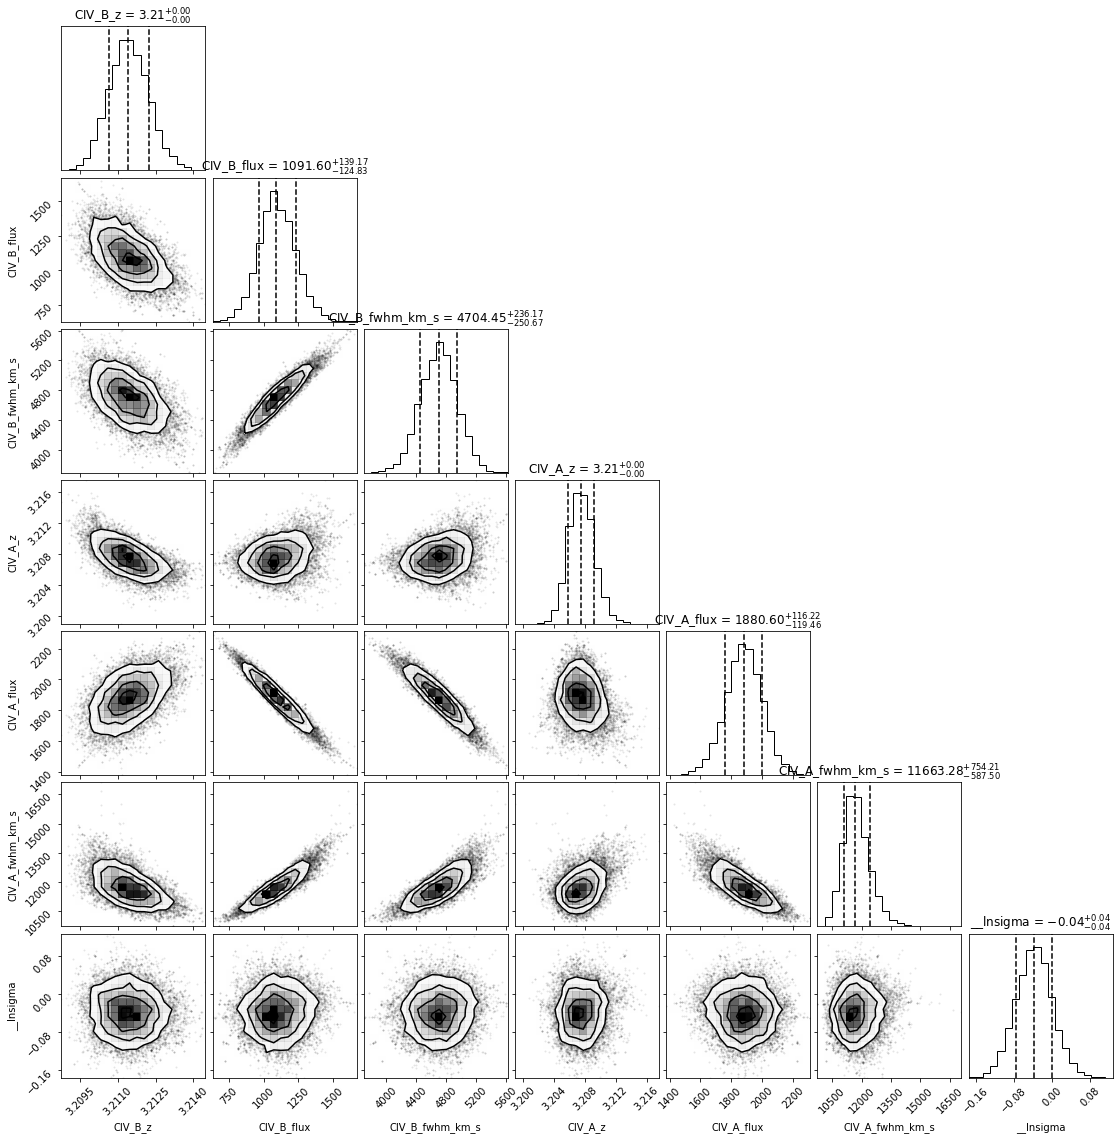

In [10]:
# Retrieve the MCMC flat chain of the CIV model fit
data = civ_model.fit_result.flatchain.to_numpy()
# Visualize the flat chain fit results using the typical corner plot
corner_plot = corner.corner(data,
                            labels=civ_model.fit_result.var_names,
                            quantiles=[0.16, 0.5, 0.84],
                            show_titles=True,
                            title_kwargs={"fontsize": 12}
                            )
plt.show()

The posterior distributions of the fit parameters look quite well behaved. It seems we have appropriately sampled the parameter space. The plot illustrates strong covariance in some variable parameters pairs (e.g., CIV_A_amp and CIV_A_fwhm_km_s). For further analysis of the MCMC fit, we will now save the flat chain in a file using the *SpecModel.save_mcmc_chain* function, which takes a folder path as an argument. We will save the flat chain in the example fit folders.

In [11]:
# Save the MCMC flatchain to a file for analysis
civ_model.save_mcmc_chain('../example_spectrum_fit')

! ls ../example_spectrum_fit/*.hdf5

../example_spectrum_fit/fit.hdf5
../example_spectrum_fit/specmodel_0_specdata.hdf5
../example_spectrum_fit/specmodel_1_specdata.hdf5
../example_spectrum_fit/specmodel_2_specdata.hdf5
../example_spectrum_fit/specmodel_3_specdata.hdf5
../example_spectrum_fit/specmodel_4_specdata.hdf5
../example_spectrum_fit/specmodel_CIV_line_mcmc_chain.hdf5
../example_spectrum_fit/spectrum.hdf5


## Analyzing the MCMC fit results

It is perfectly fine to work with the parameter fit results from the MCMC fit. However, we do have the full flat chain information and, therefore, it may be better to get posterior distributions for all the properties of the continuum or feature we are interested in. 

In a previous notebook tutorial we covered how to use *SpecAnalysis* to analyze our model fits. To construct posterior distributions of the CIV emission line properties we will now use the high-level *SpecAnalysis* function *analyze_mcmc_results*, which uses the *SpecAnalysis.analyze_continuum* and *SpecAnalysis.analyze_emission_feature* we have introduced earlier.

In [12]:
# Import the SpecAnalysis and Cosmology modules
from sculptor import specanalysis as scana
from astropy.cosmology import FlatLambdaCDM

We begin our analysis by specfiying the Cosmology we will be using and then import the model fit. 

In [13]:
# Define Cosmology for cosmological conversions
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

# Instantiate an empty SpecFit object
fit = scfit.SpecFit()
# Load the example spectrum fit
fit.load('../example_spectrum_fit')

The *analyze_mcmc_results* function is designed to automatically analyze the output of the MCMC analysis. The user specifies the folder with the MCMC output data and the function will search for any *_mcmc_chain.hdf5* files. As a second argument the function requires the full model fit information (SpecFit object). The third and fourth argument are dictionaries, *continuum_listdict* and *emission_feature_listdict*, which specify which continuum models and features should be analyzed.  

The *continuum_listdict* and the *emission_feature_listdict* hold the arguments for the *SpecAnalysis.analyze_continuum* and *SpecAnalysis.analyze_emission_feature* functions that will be called by the MCMC analysis procedure. 

The following parameters should be specified in the *continuum_listdict*:
* 'model_names' - list of model function prefixes for the full continuum model
* 'rest_frame_wavelengths' - list of rest-frame wavelengths (float) for which fluxes, luminosities and magnitudes should be calculated

The other arguments for the *SpecAnalysis.analyze_continuum* are provided to the MCMC analysis function separately.

The following parameters should be specified in the *emission_feature_listdict*:
* 'feature_name' - name of the emission feature, which will be used to name the resulting measurements in the output file
* 'model_names' - list of model names to create the emission feature model flux from
* 'rest_frame_wavelength' - rest-frame wavelength of the emission feature

Additionally, one can specify:
* 'disp_range' - 2 element list holding the lower and upper dispersion boundaries flux density integration

For a list of all arguments and keyword arguments, have a look at the function header:
    
    :param foldername: Path to the folder with the MCMC flat chain hdf5 files.
    :type foldername: string
    :param specfit: Sculptor model fit (SpecFit object) containing the
        information about the science spectrum, the SpecModels and parameters.
    :type specfit: sculptor.specfit.SpecFit
    :param continuum_dict: The *continuum_listdict* holds the arguments for
        the *SpecAnalysis.analyze_continuum* function that will be called by
        this procedure.
    :type continuum_dict: dictionary
    :param emission_feature_dictlist: The *emission_feature_listdict* hold the
        arguments for the *SpecAnalysis.analyze_emission_feature* functions that
        will be called by this procedure.
    :type emission_feature_dictlist: dictionary
    :param redshift: Source redshift
    :type: float
    :param cosmology: Cosmology for calculation of absolute properties
    :type cosmology: astropy.cosmology.Cosmology
    :param emfeat_meas: This keyword argument allows to specify the list of
        emission feature measurements.
        Currently possible measurements are ['peak_fluxden', 'peak_redsh', 'EW',
        'FWHM', 'flux']. The value defaults to 'None' in which all measurements
        are calculated
    :type emfeat_meas: list(string)
    :param cont_meas: This keyword argument allows to specify the list of
        emission feature measurements.
        Currently possible measurements are ['peak_fluxden', 'peak_redsh', 'EW',
        'FWHM', 'flux']. The value defaults to 'None' in which all measurements
        are calculated
    :type cont_meas: list(string)
    :param dispersion: This keyword argument allows to input a dispersion
        axis (e.g., wavelengths) for which the model fluxes are calculated. The
        value defaults to 'None', in which case the dispersion from the SpecFit
        spectrum is being used.
    :type dispersion: np.array
    :param width: Window width in dispersion units to calculate the average
        flux density in.
    :type width: [float, float]
    :param concatenate: Boolean to indicate whether the MCMC flat chain and
        the analysis results should be concatenated before written to file.
        (False = Only writes analysis results to file; True = Writes analysis
        results and MCMC flat chain parameter values to file)
    :type concatenate: bool

**IMPORTANT: Only model functions that are sampled together can be analyzed together. Therefore, only model functions from ONE SpecModel can be analyzed together.**

**THIS MEANS: For example, if you wanted to analyze the continuum model and the CIV emission line together using MCMC, you would have to fit them with ONE SpecModel. In our setup we have separate SpecModels for the continuum and the CIV line. Therefore, we cannot do that. However, to calculate the CIV equivalent width we need the continuum model. In this case we still need to specify the continuum model prefix for the analysis routine. It will build the best-fit continuum model and use it for the CIV analysis. As the best-fit continuum model was subtracted before the CIV line was fit using MCMC, this is the correct way of analzying the results as well.**


What does the *analyze_mcmc_results* actually do?

It identifies for which of the specified models (continuum/features) it can find the necessary MCMC flat chain information. If multiple continuum or feature models have been specified it will go through them one by one. For each entry in the flat chain file it will read in the model function parameters, build the model fluxes, and then analyze the model using the *SpecAnalysis.analyze_continuum* and *SpecAnalysis.analyze_emission_feature* functions. If you have very long MCMC chains, this process can easily take several minutes. A progress bar will keep you informed.

What is the result of the *analyze_mcmc_results* function?

The function will write an "Enhanced Character Separated Values" csv file to the same folder with the MCMC flat chain data. The csv file can be read in and then further manipulated with *astropy*. **Unit information on physical quantities is saved along with the values to the csv file.**

Let us now set up both dictionaries for our example:

In [14]:
continuum_listdict = {'model_names': ['PL_'],
                      'rest_frame_wavelengths': [1450, 1280]}

emission_feature_listdict = [{'feature_name': 'CIV',
                             'model_names' : ['CIV_A_', 'CIV_B_'],
                             'rest_frame_wavelength': 1549.06}
                                 ]

And then run the *analyze_mcmc_results* function:

In [15]:
scana.analyze_mcmc_results('../example_spectrum_fit', fit,
                           continuum_listdict,
                           emission_feature_listdict,
                           fit.redshift, cosmo)

  0%|          | 14/18750 [00:00<02:14, 138.92it/s]

[INFO] Starting MCMC analysis
[INFO] Working on output file ../example_spectrum_fit/specmodel_CIV_line_mcmc_chain.hdf5
[INFO] Analyzing emission feature CIV


100%|██████████| 18750/18750 [02:09<00:00, 145.09it/s]


It can take a while until the MCMC anlysis finishes. The results are written into the same folder with the MCMC flat chain data. In our case we can find the analyzed results (*mcmc_analysis_CIV.csv*) in 

In [16]:
! ls ../example_spectrum_fit/

0_PL__model.json                   mcmc_analysis_CIV.csv
0_fitresult.json                   specmodel_0_FitAll_fit_report.txt
1_SiIV_A__model.json               specmodel_0_specdata.hdf5
1_SiIV_B__model.json               specmodel_1_FitAll_fit_report.txt
1_fitresult.json                   specmodel_1_specdata.hdf5
2_CIV_A__model.json                specmodel_2_FitAll_fit_report.txt
2_CIV_B__model.json                specmodel_2_specdata.hdf5
2_fitresult.json                   specmodel_3_FitAll_fit_report.txt
3_CIII__model.json                 specmodel_3_specdata.hdf5
3_fitresult.json                   specmodel_4_FitAll_fit_report.txt
4_Abs_A_model.json                 specmodel_4_specdata.hdf5
4_Abs_B_model.json                 specmodel_CIV_line_mcmc_chain.hdf5
4_fitresult.json                   spectrum.hdf5
fit.hdf5


The analyzed data is saved in the enhanced csv format from astropy. We use *astropy.table.QTable* to read the file in, retaining the unit information on the analyzed properties. 

In [17]:
from astropy.table import QTable

t = QTable.read('../example_spectrum_fit/mcmc_analysis_CIV.csv', format='ascii.ecsv')
t

CIV_peak_fluxden,CIV_peak_redsh,CIV_EW,CIV_FWHM,CIV_flux,CIV_lum
erg / (Angstrom cm2 s),,Angstrom,km / s,erg / (cm2 s),erg / s
float64,float64,float64,float64,float64,float64
1.7025458953823565e-16,3.2114519863017534,33.11496431713009,6266.596338612362,2.961265327675218e-14,2.7272731887439896e+45
1.6721664115085754e-16,3.210481058669064,32.99822135043035,6460.856063522636,2.9499538664435997e-14,2.716855532259717e+45
1.723933433168788e-16,3.2114519863017534,33.469930987621815,6088.369860660105,2.9935535993120595e-14,2.757010117996179e+45
1.7182794771269916e-16,3.210481058669064,33.31534363653506,6173.896793403524,2.979287938638493e-14,2.743871695879414e+45
1.6878815917188721e-16,3.210481058669064,33.161937379596345,6455.038209974451,2.966046822693796e-14,2.7316768614052704e+45
1.7320789412335437e-16,3.2114519863017534,33.78160061683048,6330.212961485504,3.0213830308964116e-14,2.7826405341256157e+45
1.6987702663876353e-16,3.2114519863017534,33.42811472924633,6367.250543886042,2.9898229578526494e-14,2.753574262946658e+45
1.7002049199831065e-16,3.2114519863017534,33.37302405915962,6409.616175461986,2.9844375270940024e-14,2.7486143761102343e+45


With the table data we can visualize the posterior distributions for all measurements and further analyze them.

Property: CIV_EW
Median: 3.33e+01 Angstrom
Lower 1-sigma: 3.29e+01 Angstrom
Upper 1-sigma: 3.37e+01 Angstrom


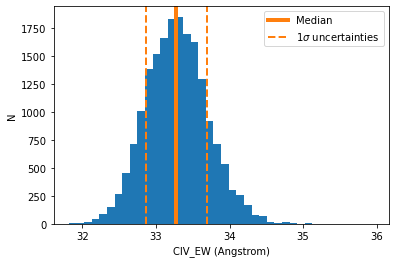

In [18]:
import numpy as np
import matplotlib.pyplot as plt

prop = 'CIV_EW'

# Calculate median, lower and upper 1-sigma range
med = np.median(t[prop])
low = np.percentile(t[prop],16)
upp = np.percentile(t[prop],84)

print('Property: {}'.format(prop))
print('Median: {:.2e}'.format(med))
print('Lower 1-sigma: {:.2e}'.format(low))
print('Upper 1-sigma: {:.2e}'.format(upp))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(t[prop].value, bins=40)
ax.axvline([med.value], ymin=0, ymax=1, color='#ff7f0e', lw=4, label='Median')
ax.axvline(low.value, ymin=0, ymax=1, color='#ff7f0e', lw=2, ls='--', label=r'$1\sigma$ uncertainties')
ax.axvline(upp.value, ymin=0, ymax=1, color='#ff7f0e', lw=2, ls='--')
plt.xlabel('{} ({})'.format(prop, med.unit))
plt.ylabel('N')
plt.legend()

plt.show()